In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/data.rar' -d '/content/drive/MyDrive/Colab Notebooks/data'

Archive:  /content/drive/MyDrive/Colab Notebooks/data.rar
replace /content/drive/MyDrive/Colab Notebooks/data/data/natural_images/cat/cat_0003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install gradio

In [10]:
#|export
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
from keras import models
import cv2 as cv
import itertools
import os
import shutil
import random
import glob
import gradio as gr
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [11]:
#|export
class ImageCreator:
        
    def __init__(self, categories, train, test, validate,augmentation_size = 10,regenerate = True):
        self.categories = categories
        self.train_size = train
        self.test_size = test
        self.validate_size = validate
        self.augments_per_class = augmentation_size#how many images for each class should we augment(each agumentation process generates 3 images)
        self.augmented_images = []
        
        
        os.chdir('/content/drive/MyDrive/Colab Notebooks/data/data/natural_images')
        print(os.getcwd())
        #removing old directories
        if regenerate:
            shutil.rmtree('Generated/train/')
            shutil.rmtree('Generated/validate/')
            shutil.rmtree('Generated/test/')
            os.mkdir('Generated/train/')
            os.mkdir('Generated/validate/')
            os.mkdir('Generated/test/')

    

    def create_random_categories(self): 
        '''
        Copying subset of dataset to the folders 
        takes 300(train_size) random files from each category
        '''
        for category in self.categories :
            #creating sub folders to hold a random subset of dataset to train / test upon
            os.mkdir('Generated/train/'+category)
            os.mkdir('Generated/validate/'+category)
            os.mkdir('Generated/test/'+category)
            
            for i in random.sample(glob.glob(category+'/'+category+'*'), self.train_size): 
                os.system('cp '+i+' Generated/train/'+category)
                
            for i in random.sample(glob.glob(category+'/'+category+'*'), self.test_size): 
                os.system('cp '+i+' Generated/test/'+category)
                
            for i in random.sample(glob.glob(category+'/'+category+'*'), self.validate_size): 
                os.system('cp '+i+' Generated/validate/'+category)
                
    def generate_images_from_categories(self):
        self.train_images = ImageDataGenerator().flow_from_directory(
                                                directory = 'Generated/train',
                                                 target_size = (224,224),
                                                 classes = self.categories,
                                                 batch_size = 16,
                                                 shuffle = True
                                                )
        
        self.validate_images = ImageDataGenerator().flow_from_directory(
                                                directory = 'Generated/validate',
                                                 target_size = (224,224),
                                                 classes = self.categories,
                                                 batch_size = 16,
                                                 shuffle = True
                                                )

        #preprocessing_function=tf.keras.applications.vgg16.preprocess_input
        self.test_images = ImageDataGenerator().flow_from_directory(
                                                directory = 'Generated/test',
                                                 target_size = (224,224),
                                                 classes = self.categories,
                                                 batch_size = 16,
                                                 shuffle = False
                                                )

        
    def generate_images_augmentation(self):
        generator = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.09,
                                   height_shift_range = 0.09,
                                   shear_range = 0.01,
                                   zoom_range = 0.15,
                                   channel_shift_range = 15,
                                   horizontal_flip = False,
                                    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input
                                    )
        
        for category in self.categories:
            for i in random.sample(glob.glob(category+'/'+category+'*'), self.augments_per_class):
                orginal_img = np.expand_dims(cv.imread(i),0)
                
                for j in range(0,20):
                    aug_img = generator.flow(orginal_img, save_to_dir='Generated/train/'+category, save_prefix='aug-image-', save_format='jpeg')
                    aug_img = [next(aug_img).astype(np.uint8)]
                    self.augmented_images.append(aug_img)
        print(len(self.augmented_images))
                
    
        

In [14]:
#|export
categ =['airplane','cat','car','dog','flower','fruit','motorbike','person']
REGENERATE = False
imagesclass = ImageCreator(categ,600,200,100,regenerate = REGENERATE)
if REGENERATE == True:
  imagesclass.create_random_categories()
  imagesclass.generate_images_augmentation()
  imagesclass.generate_images_from_categories()


/content/drive/MyDrive/Colab Notebooks/data/data/natural_images
1600
Found 6385 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


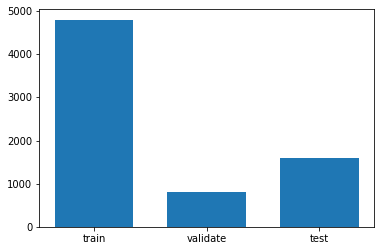

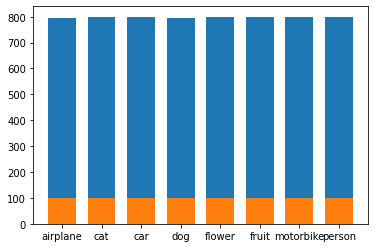

In [15]:
total_train_count = len(glob.glob('Generated/train/*/*.jpg'))
total_validation_count = len(glob.glob('Generated/validate/*/*.jpg'))
total_test_count = len(glob.glob('Generated/test/*/*.jpg'))

#ploting total data distribution 
plt.bar(['train','validate','test'], [total_train_count,total_validation_count,total_test_count], width=-0.7)
plt.show()

#ploting training data distribution
train_distribution = []
for category in categ:
      train_distribution.append(len(glob.glob('Generated/train/'+category+'/*')) )

plt.bar(categ,train_distribution , width=-0.7)
#ploting validation data distribution
valid_distribution = []
for category in categ:
      valid_distribution.append(len(glob.glob('Generated/validate/'+category+'/*')) )

plt.bar(categ,valid_distribution , width=-0.7)
plt.show()

In [16]:
#|export
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

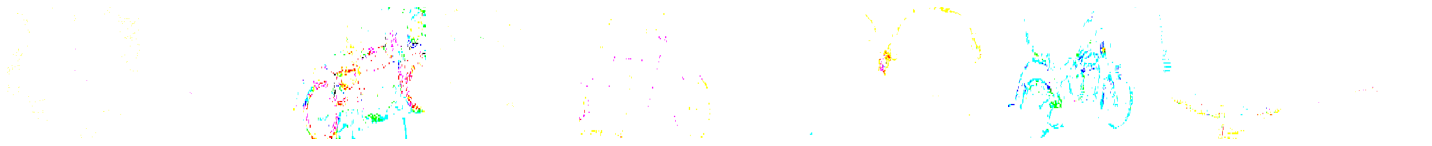

['airplane', 'cat', 'car', 'dog', 'flower', 'fruit', 'motorbike', 'person']
[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [17]:
imgs,labels = imagesclass.train_images.next() # returns next batch
plotImages(imgs)
print(categ)
print(labels)

In [22]:
#|export
class CNN:
    def __init__(self,categories,img_width,img_height):
        self.model = Sequential([Conv2D(filters = 265,kernel_size = (3,3),activation = 'relu',padding = 'same',input_shape = (img_width,img_height,3))
                                ,BatchNormalization()
                                ,MaxPool2D(pool_size=(2,2),strides = 2,padding ='valid')

                                ,Conv2D(filters = 128,kernel_size = (3,3),activation = 'relu',padding = 'same')
                                ,BatchNormalization()
                                ,MaxPool2D(pool_size=(2,2),strides = 2,padding ='valid')
                                
                                ,Conv2D(filters = 64,kernel_size = (3,3),activation = 'relu',padding = 'same')
                                ,BatchNormalization()
                                ,MaxPool2D(pool_size=(2,2),strides = 2,padding ='valid')
                                
                                ,Conv2D(filters = 32,kernel_size = (3,3),activation = 'relu',padding = 'same')
                                ,BatchNormalization()
                                ,MaxPool2D(pool_size=(2,2),strides = 2,padding ='valid')
                                ,Flatten()
                                ,Dense(units = len(categories),activation = 'softmax')]
                                )
        self.model.compile(optimizer = Adam(learning_rate = 0.001),loss = 'categorical_crossentropy',metrics = ['accuracy'])
        
    def fit(self,input_batch,valid_batch):
        self.model.fit(x=input_batch,
                       steps_per_epoch =len(input_batch),
                       shuffle = True,
                       validation_data = valid_batch,
                       validation_steps = len(valid_batch),
                       epochs=16,
                       verbose = 1)
    def predict_img(self,img):
        img = cv.resize(img,(224,224))
        img = np.reshape(img,[1,224,224,3])
        #preprocess_input(img)
        return self.model.predict(x=img,steps=1,verbose =0)

In [23]:
#|export
TRAINING = False
cnn = CNN(categ,224,224)
if TRAINING:
    cnn.fit(imagesclass.train_images,imagesclass.validate_images)
    cnn.model.save('/content/drive/MyDrive/Colab Notebooks/FinalModel.h5')
else:
    cnn.model = models.load_model('/content/drive/MyDrive/Colab Notebooks/FinalModel.h5')
cnn.model.summary()

Epoch 1/16
400/400 [==============================] - 85s 180ms/step - loss: 0.8149 - accuracy: 0.7857 - val_loss: 0.9096 - val_accuracy: 0.8025
Epoch 2/16
400/400 [==============================] - 71s 177ms/step - loss: 0.3637 - accuracy: 0.8968 - val_loss: 0.6533 - val_accuracy: 0.8725
Epoch 3/16
400/400 [==============================] - 70s 176ms/step - loss: 0.2530 - accuracy: 0.9242 - val_loss: 0.2942 - val_accuracy: 0.9225
Epoch 4/16
400/400 [==============================] - 70s 174ms/step - loss: 0.1381 - accuracy: 0.9561 - val_loss: 0.1585 - val_accuracy: 0.9625
Epoch 5/16
400/400 [==============================] - 70s 174ms/step - loss: 0.1464 - accuracy: 0.9552 - val_loss: 0.1246 - val_accuracy: 0.9688
Epoch 6/16
400/400 [==============================] - 70s 175ms/step - loss: 0.1186 - accuracy: 0.9634 - val_loss: 0.3735 - val_accuracy: 0.9150
Epoch 7/16
400/400 [==============================] - 70s 174ms/step - loss: 0.0883 - accuracy: 0.9712 - val_loss: 0.4392 - val_ac

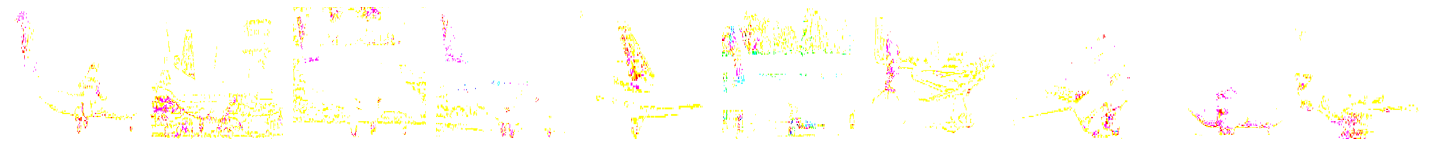

['airplane', 'cat', 'car', 'dog', 'flower', 'fruit', 'motorbike', 'person']
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [24]:
imgs,labels = imagesclass.test_images.next() # returns next batch
plotImages(imgs)
print(categ)
print(labels)

In [25]:
predicitons_prob = cnn.model.predict(x = imagesclass.test_images,steps = len(imagesclass.test_images),verbose =0)
predicitons_prob

array([[1.0000000e+00, 4.9394936e-31, 5.7170803e-29, ..., 2.9433734e-21,
        6.0269739e-31, 5.8992744e-31],
       [1.0000000e+00, 1.2936796e-18, 7.3559154e-18, ..., 7.3383011e-29,
        3.0969928e-16, 6.5471229e-20],
       [1.0000000e+00, 4.4520537e-24, 6.6647406e-16, ..., 5.1344636e-29,
        3.0543932e-15, 2.8722522e-21],
       ...,
       [3.8401499e-17, 2.5809973e-18, 3.7985315e-06, ..., 8.5751461e-16,
        7.1933586e-18, 9.9999619e-01],
       [3.8781299e-25, 1.2637956e-11, 9.1868201e-11, ..., 6.9469561e-25,
        5.5845212e-20, 1.0000000e+00],
       [2.6766140e-26, 2.2094302e-14, 1.8168955e-16, ..., 7.6810643e-21,
        5.4475811e-22, 1.0000000e+00]], dtype=float32)

In [26]:
#|export
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[199   0   1   0   0   0   0   0]
 [  1 184   1  12   1   1   0   0]
 [  0   0 198   0   1   0   1   0]
 [  1  11   1 187   0   0   0   0]
 [  1   2   3   5 187   2   0   0]
 [  0   0   0   0   0 200   0   0]
 [  0   0   1   0   0   0 199   0]
 [  0   1   0   0   0   0   0 199]]


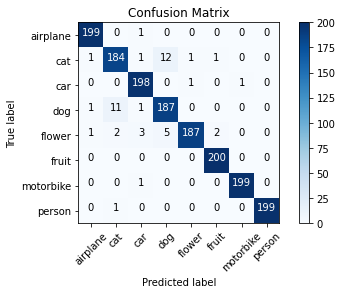

In [27]:
cm = confusion_matrix(y_true = imagesclass.test_images.classes, y_pred=np.argmax(predicitons_prob, axis=-1))
plot_confusion_matrix(cm=cm, classes=categ, title='Confusion Matrix')

# grado interface : 
* it has many ready component like image selction and drawing , you can give it a function to call each time a user submits the img.
* we will be uploading our appication onto fast ai's platform to be public, which requires a script instead of notebook

### Exporting Celling into a script

* all cells that you need to ourput to a python script you need to put #|export at it's top
* to give file a name use #|default_exp name
* #%time prints the time of the next command excueted


In [28]:
#|default_exp app

In [29]:
def gradio_function(img):
    prediction = cnn.predict_img(img).flatten()
    return dict(zip(categ, tuple(prediction.tolist()) ) )

Generated/train/dog/dog_0283.jpg


{'airplane': 9.106329454944815e-17,
 'cat': 2.1863713755010394e-06,
 'car': 1.6382029066619452e-09,
 'dog': 0.9999978542327881,
 'flower': 2.0573540093771214e-10,
 'fruit': 8.39634312983381e-18,
 'motorbike': 2.787480749694149e-12,
 'person': 2.0113904986018838e-10}

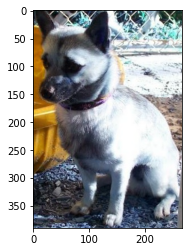

In [52]:
randompath = random.choice(glob.glob('*/*/*/*'))
img = cv.imread(randompath)
plt.imshow(img)
print(randompath)
gradio_function(img) #this is the required format of gradio print out method

In [ ]:
img = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label()
interface = gr.Interface(fn = gradio_function,inputs = img,outputs = label)
interface.launch(inline = False)

**Exporting python script**


In [4]:
!pip3 install nbdev

#!nbdev_build_lib
from nbdev.export import *
notebook2script()


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 783.6 kB/s eta 0:00:00 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


NameError: name 'notebook2script' is not defined